In [90]:
import sys
assert sys.version_info >= (3,5)

import sklearn
assert sklearn.__version__>= "0.20"

import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('axes',labelsize=14)
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick',labelsize=12)

import torch
import random
import torch.utils.data as data_utils
import torch.nn.functional as F

In [91]:
url  = 'https://raw.githubusercontent.com/hargurjeet/MachineLearning/Wheat-Seeds/seeds.csv'
df = pd.read_csv(url)
df.head()

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove,Type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


array([[<AxesSubplot:title={'center':'Area'}>,
        <AxesSubplot:title={'center':'Perimeter'}>,
        <AxesSubplot:title={'center':'Compactness'}>],
       [<AxesSubplot:title={'center':'Kernel.Length'}>,
        <AxesSubplot:title={'center':'Kernel.Width'}>,
        <AxesSubplot:title={'center':'Asymmetry.Coeff'}>],
       [<AxesSubplot:title={'center':'Kernel.Groove'}>,
        <AxesSubplot:title={'center':'Type'}>, <AxesSubplot:>]],
      dtype=object)

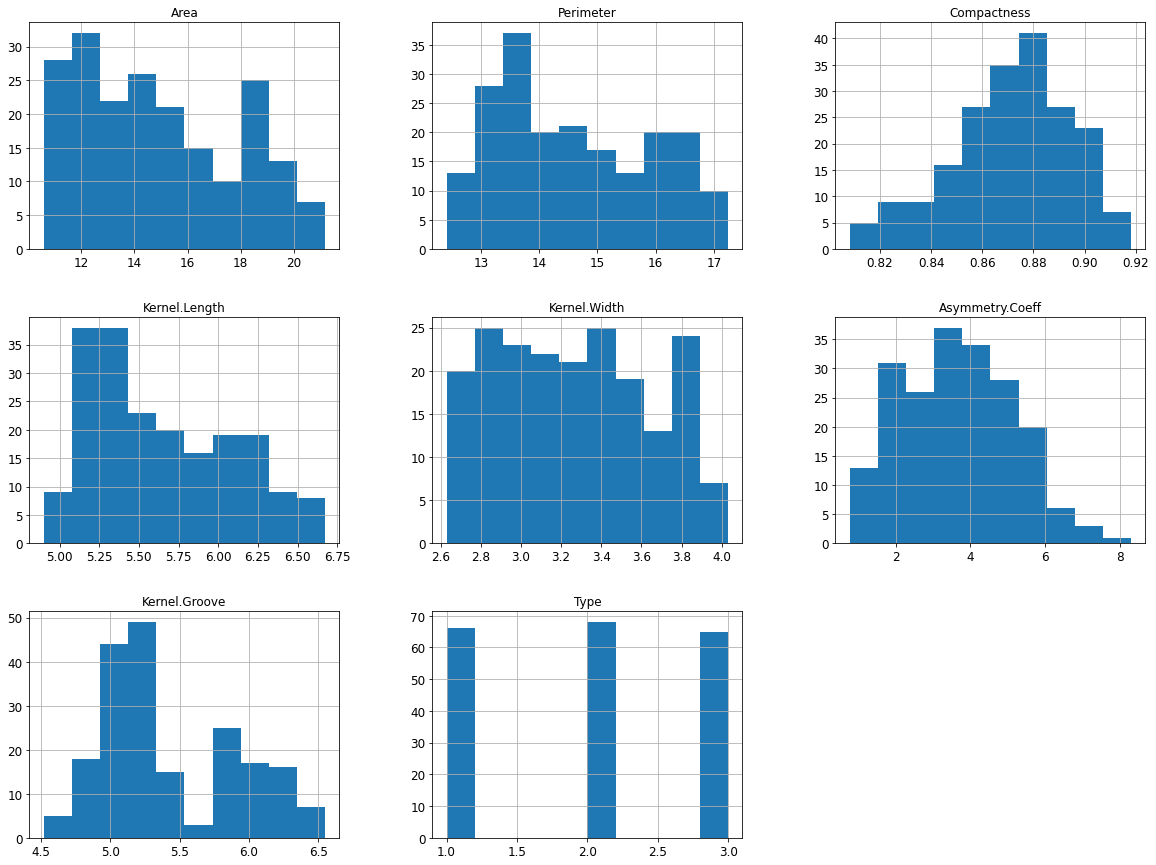

In [92]:
df.hist(figsize=(20,15))


In [93]:
df.corr()

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove,Type
Area,1.000000,0.994437,0.609887,0.951126,0.970980,-0.222820,0.862727,-0.340664
Perimeter,0.994437,1.000000,0.531841,0.972944,0.945496,-0.211034,0.889543,-0.322223
Compactness,0.609887,0.531841,1.000000,0.374011,0.762167,-0.329400,0.227016,-0.539261
Kernel.Length,0.951126,0.972944,0.374011,1.000000,0.862680,-0.169704,0.932124,-0.249422
Kernel.Width,0.970980,0.945496,0.762167,0.862680,1.000000,-0.253122,0.748228,-0.421961
Asymmetry.Coeff,-0.222820,-0.211034,-0.329400,-0.169704,-0.253122,1.000000,-0.003349,0.573956
Kernel.Groove,0.862727,0.889543,0.227016,0.932124,0.748228,-0.003349,1.000000,0.035508
Type,-0.340664,-0.322223,-0.539261,-0.249422,-0.421961,0.573956,0.035508,1.000000


<AxesSubplot:xlabel='Area', ylabel='Kernel.Length'>

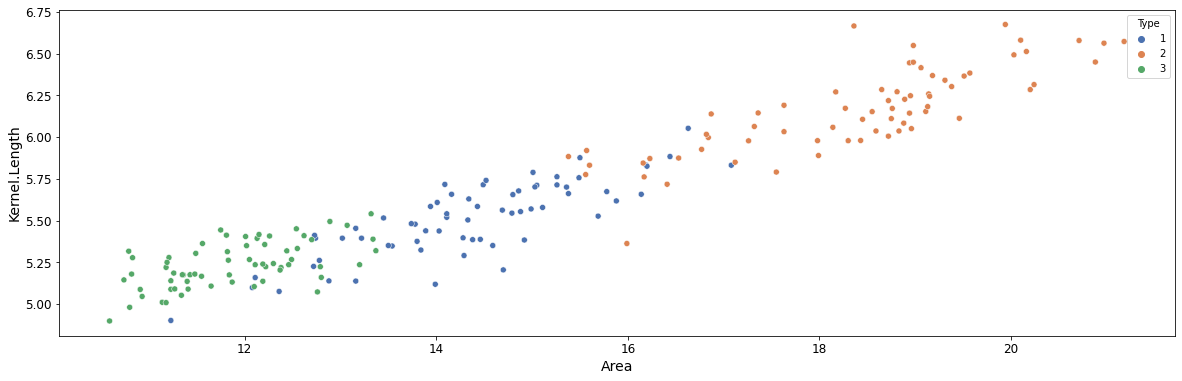

In [94]:
plt.rcParams["figure.figsize"] = (20,6)
sns.scatterplot(data=df, x = "Area",y="Kernel.Length",hue="Type",palette ="deep")

<AxesSubplot:xlabel='Area', ylabel='Kernel.Width'>

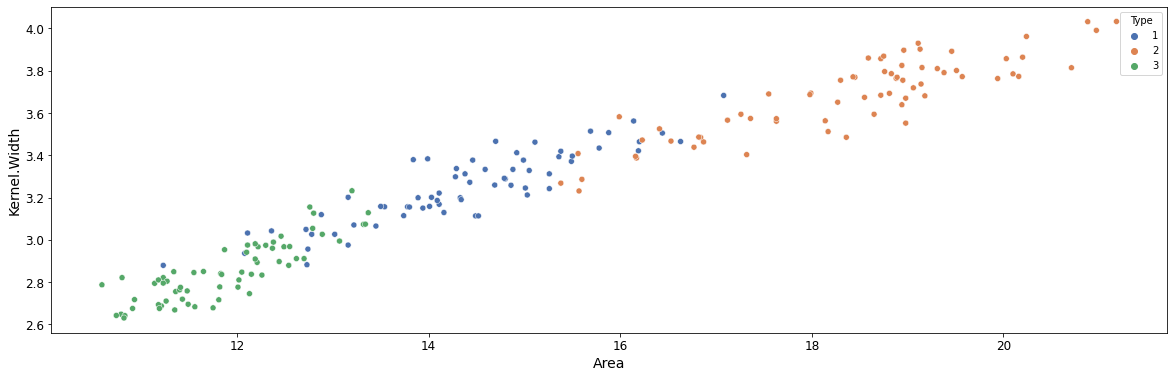

In [95]:
sns.scatterplot(data=df, x = "Area",y="Kernel.Width",hue="Type",palette ="deep")

<AxesSubplot:xlabel='Kernel.Groove', ylabel='Perimeter'>

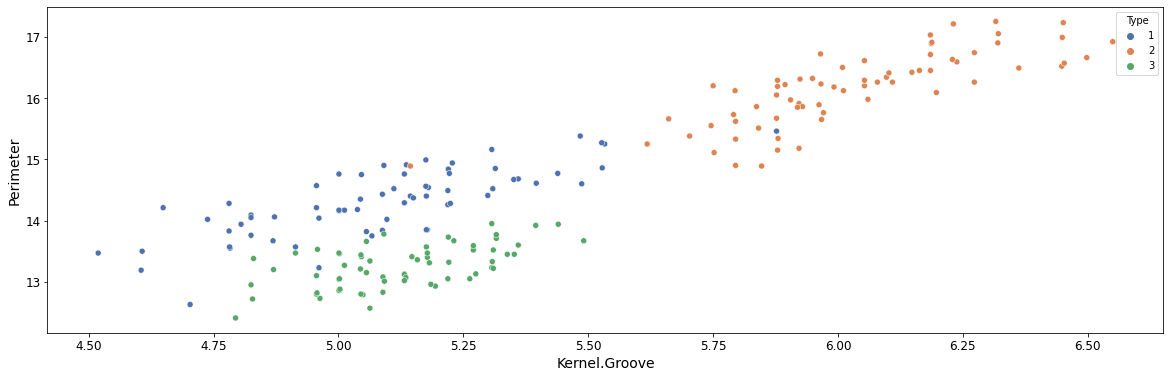

In [96]:
sns.scatterplot(data=df,x="Kernel.Groove",y="Perimeter",hue="Type",palette="deep")

In [97]:
from torch.utils.data import random_split
import torch
import random
from torch.utils.data import TensorDataset

def update_values_(df):
    for i in range(len(df)):
        df[i] = df[i] - 1
    return df

train_target = torch.tensor(df['Type'].values.astype(np.int64))
train = torch.tensor(df.drop('Type',axis=1).values.astype(np.float32))

train_tensor = TensorDataset(train,update_values_(train_target))
train_ds,val_ds = random_split(train_tensor,[180,19])
len(train_ds),len(val_ds)

(180, 19)

In [98]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_ds,batch_size,shuffle=True)
val_loader = DataLoader(val_ds,batch_size)

In [99]:
import torch.nn as nn

input_size = 1*7
num_classes = 3
model = nn.Linear(input_size,num_classes)

In [100]:
class Wheatseed(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,num_classes)
    
    def forward(self,xb):
        out = self.linear(xb)
        return out

model = Wheatseed()

In [101]:
model.linear

Linear(in_features=7, out_features=3, bias=True)

In [102]:
class Wheatseed(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,num_classes)
    
    def forward(self,xb):
        out = self.linear(xb)
        return out
    
    def training_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {'val_loss':loss,'val_acc':acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}
    
    def epoch_end(self,epoch,result):
        print("Epoch [{}],val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['val_loss'],result['val_acc']))

model = Wheatseed()

In [103]:
def accuracy(outputs,labels):
    _, preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [104]:
result0 = evaluate(model,val_loader)
result0

{'val_loss': 6.616847038269043, 'val_acc': 0.3684210479259491}

In [105]:
def fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(),lr)
    history = []
    
    for epoch in range(epochs):
        
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        result = evaluate(model,val_loader)
        model.epoch_end(epoch,result)
        history.append(result)
    return history


def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [106]:
history1 = fit(5,0.001,model,train_loader,val_loader)

Epoch [0],val_loss: 5.8241, val_acc: 0.3684
Epoch [1],val_loss: 5.0319, val_acc: 0.3684
Epoch [2],val_loss: 4.2373, val_acc: 0.3684
Epoch [3],val_loss: 3.4466, val_acc: 0.3684
Epoch [4],val_loss: 2.6720, val_acc: 0.3684


In [107]:
history2 = fit(5,0.001,model,train_loader,val_loader)

Epoch [0],val_loss: 1.9687, val_acc: 0.3684
Epoch [1],val_loss: 1.4185, val_acc: 0.3684
Epoch [2],val_loss: 1.1053, val_acc: 0.3684
Epoch [3],val_loss: 0.9970, val_acc: 0.3684
Epoch [4],val_loss: 0.9603, val_acc: 0.5789


In [108]:
history3 = fit(5,0.001,model,train_loader,val_loader)

Epoch [0],val_loss: 0.9505, val_acc: 0.5789
Epoch [1],val_loss: 0.9437, val_acc: 0.5263
Epoch [2],val_loss: 0.9329, val_acc: 0.6316
Epoch [3],val_loss: 0.9301, val_acc: 0.6316
Epoch [4],val_loss: 0.9327, val_acc: 0.6842


In [109]:
history4 = fit(5,0.001,model,train_loader,val_loader)

Epoch [0],val_loss: 0.9307, val_acc: 0.6842
Epoch [1],val_loss: 0.9233, val_acc: 0.6842
Epoch [2],val_loss: 0.9176, val_acc: 0.6316
Epoch [3],val_loss: 0.9194, val_acc: 0.6842
Epoch [4],val_loss: 0.9165, val_acc: 0.6842


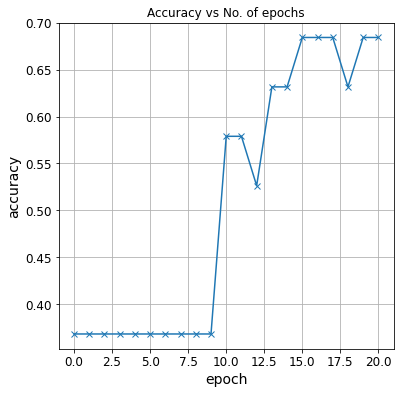

In [110]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.rcParams["figure.figsize"] = (6,6)
plt.plot(accuracies,'-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.title('Accuracy vs No. of epochs')
plt.show()